# TEXT SUMMARIZATION

# Problem Statement

Customer reviews can be lengthy and detailed. Manually analysing these reviews, as you might guess, takes a long time. This is where Natural Language Processing's application can be put to use to develop a short summary for lengthy reviews.

Our objective here is to generate a summary for the **"Amazon Fine Food reviews"** using the **abstraction-based** and as well as **extraction-based** text summarization approaches.

# Project pipeline

1. Understanding Text Summarization
2. Text pre-processing
3. Abstractive Text Summarization using LSTM, ENCODER-DECODER architecture
4. Extractive Text Summarization using Transformer

## 1. Understanding Text Summarization

**Text summarization** is a Natural Language Processing application which produces short and meaningful summary of a lengthy paragraph thereby helping us to understand the essence of the topic in an efficient way.

**Types of Text Summarization**

1. Abstrative Based
2. Extractive Based



In Abstractive based, we generate new sentences from the original text. The sentences generated through abstractive summarization might not be present in the original text.

In Extractive based, we identify the important sentences or phrases from the original text and extract only those from the text. Those extracted sentences would be our summary.

Custom Attention Layer: Keras does not officially support attention layer. We will use a third-party implementation.

## Import the Libraries

In [ ]:
#You can mount google drive for file data
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)

DATA_PATH = os.path.abspath(os.path.join('/content/drive', 'My Drive/data'))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, "Reviews.csv"))


Mounted at /content/drive


In [ ]:
!pip install numpy nltk csv numpy itertools
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
#from attention import AttentionLayer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')


ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 50,000 reviews to reduce the training time of our model.

**Download link for Reviews.csv **
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download

In [ ]:
#data = pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv")
data = pd.read_csv(train_filenamepath)

In [ ]:
#OR Comment out the first and third cell and uncomment the below line if Reviews.csv is uploaded in colab Files
#data = pd.read_csv('Reviews.csv')

## Drop Duplicates and NA values

In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

## 2. Text Pre-processing

Before we start developing the model, we must first complete some basic preprocessing tasks. Using messy and sloppy text data can be devastating. As a result, in this stage, we will remove all unneeded symbols, characters, and other elements from the text that do not affect the problem's goal.

Here is the dictionary that we will use for expanding the contractions:

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below pre-processing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove single characters

**Let’s define the function for performing the above pre-processing steps**

In [ ]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
# Cleaning the "Text" Column

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

Let us look at the first 2 preprocessed reviews

In [ ]:
cleaned_text[:2]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']

In [ ]:
# Cleaning the "Summary" Column

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 2 preprocessed summaries

In [ ]:
cleaned_summary[:2]

['good quality dog food', 'not as advertised']

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

## Drop empty rows

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

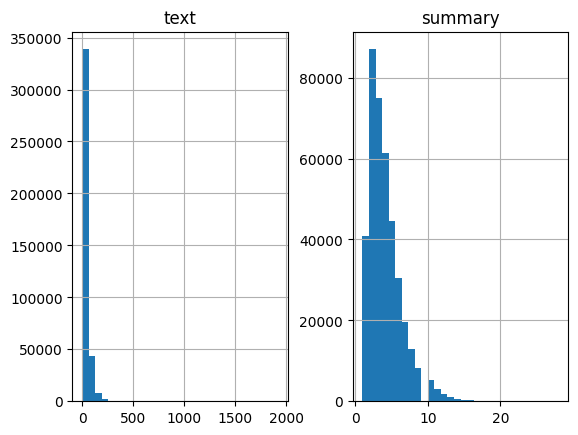

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

**NOTE: We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.**

Let us understand the proportion of the length of summaries below 8

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9458123944578951


**We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.**

In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 30):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.5597927814286586


Let us fix the maximum length of review to 30

In [ ]:
max_text_len=30
max_summary_len=8

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

In [ ]:
# add the START and END special tokens at the beginning and end of the summary. Here, We have chosen sostok and eostok as START and END tokens

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok


## Train-Test Split and Prepare the Tokenizer

In [ ]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=0, shuffle=True)

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

## Rarewords and its Coverage on Reviews column

The threshold is taken as 4 which means word whose count is below 4 is considered as a **rare word**

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 68.03323494041761
Total Coverage of rare words: 1.4416020340809668


In [ ]:
print(cnt),print(tot_cnt)

37338
54882


(None, None)

In [ ]:
print(freq),print(tot_freq)

50189
3481474


(None, None)

NOTE:

* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)

*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words

Let us define the tokenizer with **top most common words** for reviews.

## Reviews Tokenizer

In [ ]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

17545

## Summary Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

## Rarewords and its Coverage on the summary column

The threshold is taken as 6 which means word whose count is below 6 is considered as a **rare word**

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.82090983174345
Total Coverage of rare words: 2.583437288749817


In [ ]:
print(cnt),print(tot_cnt)

15817
20861


(None, None)

In [ ]:
print(freq),print(tot_freq)

25949
1004437


(None, None)

Let us define the tokenizer with **top most common words for summary**.

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
#deleting the rows that contain only START and END tokens

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Abstractive Text Summarization - Model building

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other.
This leads to a better representation of the sequence.

Here, we are building a 3 stacked LSTM for the encoder:

In [ ]:
trstingcell=1+2

In [ ]:
!pip install keras-self-attention
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K # Import Keras backend
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import nltk
from keras_self_attention import SeqSelfAttention # Import SeqSelfAttention


  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=72e35ada329d68fbab90a6ad8b6449ad025bc62a5b55f0fd28b6ff89f1d37db5
  Stored in directory: /root/.cache/pip/wheels/46/f9/96/709295c836133071c12a300729fed4027757f889c01695feea
Successfully built keras-self-attention


In [ ]:
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#COMMENT BELOW LINES FOR MODELING WITHOUT ATTENTION
attn_layer = SeqSelfAttention(attention_activation='sigmoid')
attn_out = attn_layer(decoder_outputs) # Apply attention to decoder outputs

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

#COMMENT OUT UPTO THE ABOVE LINES AND ADD UNCOMMENT BELOW TWO LINES FOR MODELING WITHOUT ATTRNTION
#decoder_dense = Dense(y_voc, activation='softmax')
#decoder_outputs = decoder_dense(decoder_outputs) # Apply the Dense layer to the decoder outputs

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 100)   │  1,754,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 30, 300), │    481,200 │ embedding[0][0]   │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 30, 300), │    721,200 │ lstm[0][0]        │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 100) │    504,500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 30, 300), │    721,200 │ lstm_1[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    481,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_self_attention  │ (None, None, 300) │     19,265 │ lstm_3[0][0]      │
│ (SeqSelfAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 600) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ seq_self_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  3,032,045 │ concat_layer[0][… │
│ (TimeDistributed)   │ 5045)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,715,110 (29.43 MB)

 Trainable params: 7,715,110 (29.43 MB)

 Non-trainable params: 0 (0.00 B)

Sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

EarlyStopping monitors the validation loss (val_loss). Our model will stop training once the validation loss increases.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

Fit the model

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=1,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

1481/1481 ━━━━━━━━━━━━━━━━━━━━ 3516s 2s/step - loss: 3.0157 - val_loss: 2.1220


## Understanding the Diagnostic plot

In [ ]:
#execute this cell only with first model.fit otherwise you need to dump the history also along with model
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Inference

Set up the inference for the encoder and decoder:

In [ ]:
'''
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
'''

"\n# Encode the input sequence to get the feature vector\nencoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])\n\n# Decoder setup\n# Below tensors will hold the states of the previous time step\ndecoder_state_input_h = Input(shape=(latent_dim,))\ndecoder_state_input_c = Input(shape=(latent_dim,))\ndecoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))\n\n# Get the embeddings of the decoder sequence\ndec_emb2= dec_emb_layer(decoder_inputs)\n# To predict the next word in the sequence, set the initial states to the states from the previous time step\ndecoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])\n\n#attention inference\nattn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])\ndecoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])\n\n# A dense softmax layer to generate prob dist. over the targe

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim)) # This line is removed

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2]) # Modified this line
attn_out_inf = attn_layer(decoder_outputs2)  # Only pass decoder outputs to attention layer
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [ ]:
for i in range(0, 10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print(encoder_model.output_shape)
    print("\n")

Review: easily best peanuts ever waaay better salted cannot stop eating start downside addictive insane amount calories 
Original summary: best peanuts ever 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted summary:  the the the the the the the
[(None, 30, 300), (None, 300), (None, 300)]


Review: read ingredients carefully instead reviews fresh garlic great garlic powder keep days alas 
Original summary: wish would it has garlic powder 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

**The Following output generated with 50 epochs of self-attention**



Review: gluten free want crackers one also delicious second order
Original summary: cracker of cracker
Predicted summary:  great gluten free baking


Review: coffee tastes like regular coffee good weak used little less water regular strength coffee taste great smell better whether works stomach needed sure
Original summary: the taste is good
Predicted summary:  good coffee


Review: first time italy wife actually give gifts well good sucks seasonal definitely makes look forward holidays
Original summary: better than crack
Predicted summary:  the best


Review: tea tasty love night little soy milk splenda would recommend people trying healthy green tea
Original summary: yummy
Predicted summary:  great tea


Review: bought cookies gifts open last long good make great gifts would definitely buy
Original summary: mouth watery cookies
Predicted summary:  best cookies ever


Review: brewed pot found strong stronger starbucks even even extra milk still strong taste acidic aftertaste think many enjoy taste
Original summary: too strong
Predicted summary:  senseo paris french vanilla coffee pods


Review: drinking years simple morning lunch tea fancy reliable always satisfying hard beat price
Original summary: very nice simple tea
Predicted summary:  great tea


Review: find balsamic vinegar great cooking salad dressings drizzled fruits cheeses veggies good flavor compliments many dishes
Original summary: leaf vinegar for good price
Predicted summary:  great product


Review: made crab used sauce dipping sauce great love fact msg right amount sweetness little spicy right amount
Original summary: really good sauce
Predicted summary:  the best


Review: coffee sample selection ordered keurig brewer far favorite ordered coffee several times amazon dark roast strong
Original summary: wolfgang puck coffee sumatra for keurig
Predicted summary:  great coffee


**Our model now able to generate a meaningful summary based on the context present in the text.**


## Text Summarization using Transformers

In [ ]:
from transformers import pipeline

Summarize news articles and other documents.
This summarizing pipeline can currently be loaded from pipeline() using the following task identifier: "summarization".
The models that this pipeline can use are models that have been fine-tuned on a summarization task, which is currently, ‘bart-large-cnn’, ‘t5-small’, ‘t5-base’, ‘t5-large’, ‘t5-3b’, ‘t5-11b’.

https://huggingface.co/t5-base

https://huggingface.co/models?filter=summarization

In [ ]:
import bs4 as bs
import urllib.request
import re

In [ ]:
scraped_data = urllib.request.urlopen('https://en.wikipedia.org/wiki/Artificial_intelligence')
article = scraped_data.read()
parsed_article = bs.BeautifulSoup(article,'lxml')
paragraphs = parsed_article.find_all('p')

In [ ]:
article_text = ""
for p in paragraphs:
    article_text += p.text

In [ ]:
article_text[0:500]

'\nArtificial intelligence (AI) refers to the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.[1] Such machines may be call'

'\n\nArtificial intelligence (AI) is intelligence demonstrated by machines, as opposed to the natural intelligence displayed by humans or animals. \nLeading AI textbooks define the field as the study of "intelligent agents": any system that perceives its environment and takes actions that maximize its chance of achieving its goals.[a] \nSome popular accounts use the term "artificial intelligence" to describe machines that mimic "cognitive" functions that humans associate with the human mind, such as '

In [ ]:
# Text preprocessing

# Removing Square Brackets and Extra Spaces
article_text = re.sub(r'\[[0-9]*\]', ' ', article_text)
article_text = re.sub(r'\s+', ' ', article_text)

In [ ]:
# Removing special characters and digits
formatted_article_text = re.sub('[^a-zA-Z]', ' ', article_text )
formatted_article_text = re.sub(r'\s+', ' ', formatted_article_text)

In [ ]:
len(formatted_article_text)

81376

44288

In [ ]:
formatted_article_text_1=formatted_article_text[0:500]


' Artificial intelligence AI is intelligence demonstrated by machines as opposed to the natural intelligence displayed by humans or animals Leading AI textbooks define the field as the study of intelligent agents any system that perceives its environment and takes actions that maximize its chance of achieving its goals a Some popular accounts use the term artificial intelligence to describe machines that mimic cognitive functions that humans associate with the human mind such as learning and prob'

In [ ]:
!pip  install tensorflow
!pip  install tf_keras
#!pip install tensorflow==2.13.0 # Choose a compatible version, if needed
#!pip install keras-nightly==2.13.0.dev2023110600 # Choose a compatible nightly version

In [ ]:
#use t5 in tf
summarizer1 = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use 0


In [ ]:
formatted_article_text_1

' Artificial intelligence AI refers to the capability of computational systems to perform tasks typically associated with human intelligence such as learning reasoning problem solving perception and decision making It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals Such machines may be called AIs High '

' Artificial intelligence AI is intelligence demonstrated by machines as opposed to the natural intelligence displayed by humans or animals Leading AI textbooks define the field as the study of intelligent agents any system that perceives its environment and takes actions that maximize its chance of achieving its goals a Some popular accounts use the term artificial intelligence to describe machines that mimic cognitive functions that humans associate with the human mind such as learning and prob'

In [ ]:
summarizer1(formatted_article_text_1, min_length=5, max_length=500,do_sample=False)

Your max_length is set to 500, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


[{'summary_text': 'artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence such as learning reasoning problem solving perception and decision making . it is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment .'}]

Your max_length is set to 500, but you input_length is only 83. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
{'summary_text': 'artificial intelligence (AI) is intelligence demonstrated by machines as opposed to the natural intelligence displayed by humans or animals . leading AI textbooks define the field as the study of intelligent agents .'}

In [ ]:
summarizer1(formatted_article_text_1, min_length=5, max_length=20,do_sample=False)

[{'summary_text': 'artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence'}]

[{'summary_text': 'AI is intelligence demonstrated by machines as opposed to the natural intelligence displayed by humans or animals .'}]



**You can try the following**

In [ ]:
text_string=data.Text[0]
text_string

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
summarizer1(text_string, min_length=5, max_length=20,do_sample=False)

[{'summary_text': 'my Labrador is finicky and appreciates this product better than most .'}]